In [1]:
from PIL import Image
import pandas as pd 
import os
import numpy as np 
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid import ImageGrid
from sklearn.model_selection import train_test_split

In [2]:
# Path to all data
DATA_PATH = "../dataset_mri/lgg-mri-segmentation/kaggle_3m/"
IMG_SIZE=224

Preprocessing 

In [3]:
from preprocessing import load_dataset

In [4]:
dataset=load_dataset(DATA_PATH)
dataset.head()

,patient_id,image_path,image_data,mask_path,mask_data,tumor
0,TCGA_CS_4941_19960909_1,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,TCGA_CS_4941_19960909_10,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[2, 3, 3, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 3, 4,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,TCGA_CS_4941_19960909_11,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[1, 1, 2, 2, 3, 2, 4, 3, 3, 3, 2, 2, 2, 3, 5,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3,TCGA_CS_4941_19960909_12,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[4, 2, 2, 4, 3, 2, 2, 2, 3, 4, 4, 3, 2, 2, 3,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
4,TCGA_CS_4941_19960909_13,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[3, 1, 2, 3, 2, 3, 4, 5, 6, 5, 3, 2, 2, 2, 4,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


In [16]:
dataset.columns

Index(['patient_id', 'image_path', 'image_data', 'mask_path', 'mask_data',
       'tumor'],
      dtype='object')

Visualisation of tumor presence frequency

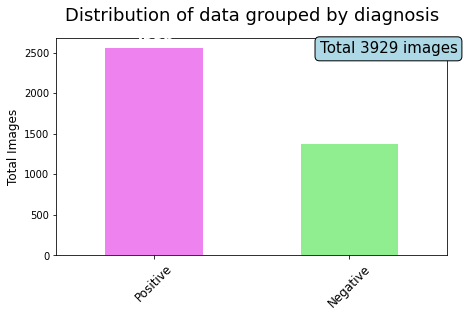

In [17]:
# Plot
ax = dataset.tumor.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(7, 4),
                                     color=["violet", "lightgreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(dataset.tumor.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(dataset)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );



Data visualisation


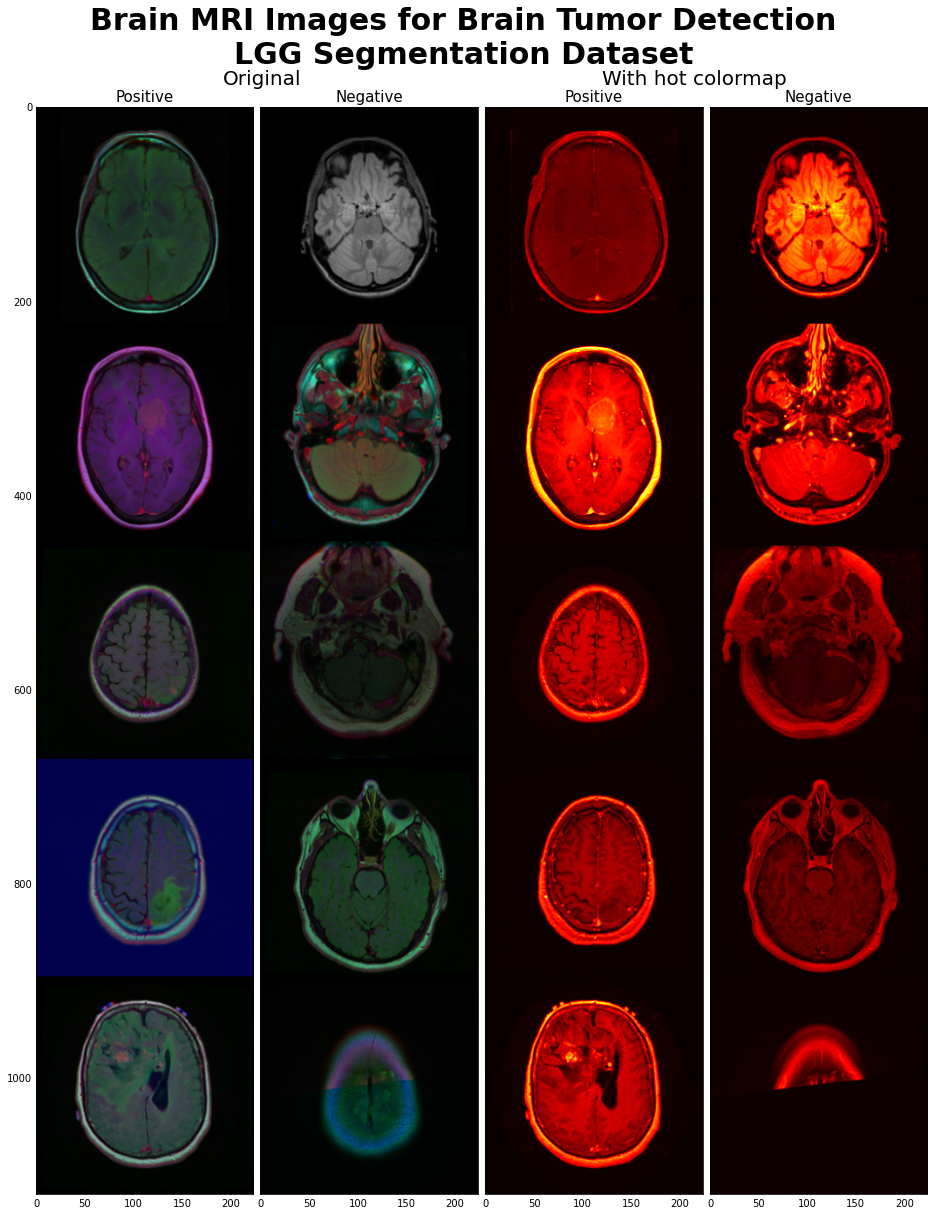

In [18]:
# Data
sample_yes_df = dataset[dataset["tumor"] == 1].sample(5).image_path.values
sample_no_df = dataset[dataset["tumor"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

Data preparation

Use pytorch dataloader to import dataset (warning folders contain both mask and images)

Template of data loader for segmentation problems

In [24]:
import torch.utils.data as data

class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = dataset['image_path']
        self.mask_files =dataset['mask_path']
    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        data = Image.open(img_path)
        label =Image.open(mask_path)
        return torch.from_numpy(data).float(), torch.from_numpy(label).float()
    def __len__(self):
        return len(self.img_files)

Autre option 

In [17]:
from preproccesing_for_classification import *
from model_classifier import *

In [6]:
train_loader,test_loader,val_loader=get_train_test_val_sets(dataset)

Train: (3005, 2) 
Val: (334, 2) 
Test: (590, 2)


In [14]:
model=build_model()

In [8]:
train_test_classification(model,train_loader,test_loader,epochs=5)

NameError: name 'train_dataloader' is not defined

Classifier

In [34]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [35]:
from model_classifier import *

In [36]:
def build_model():
    model = Net()
    # defining the optimizer
    optimizer = Adam(model.parameters(), lr=0.07)
    # defining the loss function
    criterion = CrossEntropyLoss()
    # checking if GPU is available
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda() 

In [37]:
model=build_model()

In [38]:
model

In [39]:
for epoch in range(10):
    # training
    model.train() # mode "train" agit sur "dropout" ou "batchnorm"
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = Variable(x).to(device), Variable(target).to(device)
        out = model(x)
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if batch_idx %100 ==0:
            print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_idx,batch_idx*len(x),
                    len(train_loader.dataset),loss.item()))

AttributeError: 'NoneType' object has no attribute 'train'